In [87]:
using CSV, DataFrames, Plots, StatsPlots, Dates, GLM;
using Pipe, StatsPlots, Underscores, Statistics, StatsBase, RollingFunctions;
# import data and clean
date_of_first_obs = Date("2020-07-01");
windowsize = 7; # set window size for aggregating data into windowsize-ly data
sub_sample_size = 90;  # 3-months
fixN_daily = 100000;  # to get adjusted case numbers
fixN_weekly = fixN_daily * 7;
fixN_7dd = fixN_daily;
Nstar = 5800000;
daily = CSV.File("pos.csv") |> DataFrame;
n = nrow(daily);
delete!(daily, n-1:n);  # last two rows contain some words instead of data, remomve them
daily = rename(daily, :Tested => :Nt, :NewPositive => :Ct) |> DataFrame; # rename Nt and Ct
daily.Nt .= replace.(daily.Nt, "." => "");  # There are dots in numbers, i.e. one thousand is written as 1.000, remove dots
daily.Nt .= replace.(daily.Nt, " " => "");
daily.Ct .= replace.(daily.Ct, "." => "");
daily.Ct .= replace.(daily.Ct, " " => "");
daily.Nt = parse.(Int, daily.Nt); # change data type from string to integers
daily.Ct = parse.(Int, daily.Ct);
daily.logNt = log.(daily.Nt); # create log(Nt)
daily.logCt = log.(daily.Ct); # create log(Ct)
daily.pihat = daily.Ct ./ daily.Nt; # calculate positive ratio
daily.pihat = replace!(daily.pihat, NaN => 0); # NaN are created bc some Nt=0, replace NaN with 0
daily.Date = Date.(daily.Date, "yyyy-mm-dd"); # change data type of Date from string to Date
n = nrow(daily);

# create daily data set 
national_daily = @pipe daily |> 
subset(_, :logCt => c -> .!isinf.(c)) |> 
select(_, :Date, :logCt, :logNt, :Ct, :Nt, :pihat) |>
transform(_, :logCt => (x -> x - lag(x)) => :diff_logCt, 
             :logNt => (x -> x - lag(x)) => :diff_logNt,
             :logNt => (x -> lag(x)) => :lag_logNt) |>
dropmissing(_) |>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs)); # drop data before 2020-07-01 ;
N_daily = nrow(national_daily);

# create rolling weekly data set
national_weekly = select(daily,
    :Date,
    :pihat,
    :Nt => (v -> runmean(v, windowsize) * windowsize) => :Nt, 
    :Ct => (v -> runmean(v, windowsize) * windowsize) => :Ct)
delete!(national_weekly, 1: (windowsize - 1));
national_weekly = @pipe national_weekly |> 
transform(_, :Nt => (x -> log.(x)) => :logNt,
             :Ct => (x -> log.(x)) => :logCt,
             :pihat => (x -> log.(x)) => :logPi) |> 
subset(_, :logCt => c -> .!isinf.(c)) |> 
transform(_, :logCt => (x -> x - lag(x)) => :diff_logCt, 
             :logNt => (x -> x - lag(x)) => :diff_logNt,
             :logPi => (x -> x - lag(x)) => :diff_logPi,
             :logNt => (x -> lag(x)) => :lag_logNt) |> 
dropmissing(_) |>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs)); # drop data before 2020-07-01 ;
N_weekly = nrow(national_weekly);

# create weekday data set, 7-day difference
national_7dd = @pipe daily |> 
subset(_, :logCt => c -> .!isinf.(c)) |> 
select(_, :Date, :logCt, :logNt, :Ct, :Nt, :pihat) |>
transform(_, :logCt => (x -> x - lag(x, 7)) => :diff_logCt, 
             :logNt => (x -> x - lag(x, 7)) => :diff_logNt,
             :logNt => (x -> lag(x)) => :lag_logNt) |>
dropmissing(_) |>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs)); # drop data before 2020-07-01 ;
N_7dd = nrow(national_7dd);

# add sub-sample index to data sets
national_daily.subsample = string.(Int.(repeat(1:ceil(N_daily/sub_sample_size), 
            inner = sub_sample_size)[1:N_daily]));
national_weekly.subsample = string.(Int.(repeat(1:ceil(N_weekly/sub_sample_size), 
            inner = sub_sample_size)[1:N_weekly]));
national_7dd.subsample = string.(Int.(repeat(1:ceil(N_7dd/sub_sample_size), 
            inner = sub_sample_size)[1:N_7dd]));
national_weekly.C_tilde = national_weekly.Ct ./ national_weekly.Nt .* Nstar;


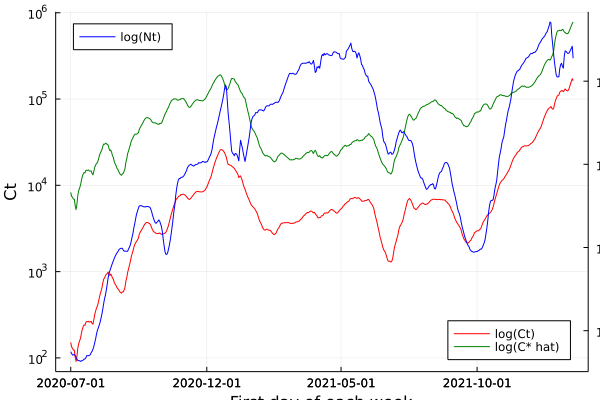

In [108]:
@df national_weekly plot(:Date, :Ct, yaxis = :log, ylabel = "Ct",
    label = "log(Ct)", color = "red", leg = :bottomright)
@df national_weekly plot!(:Date, :C_tilde, yaxis = :log, ylabel = "Ct",
    label = "log(C* hat)", color = "green", leg = :bottomright)
@df national_weekly plot!(twinx(), :Date, :Nt, yaxis = :log, ylabel = "Nt", xlabel = "First day of each week",
    label = "log(Nt)", color = "blue", leg = :topleft)
png("i1")

In [16]:
nstar = log(5800000);
using Optim;
function recoverBeta(θ, data)
    x1 = data.logNt;
    x2 = data.lag_logNt;
    y = data.diff_logCt;
    T = nrow(data);
    ω = θ[1]; 
    ϕ = θ[2];
    α = θ[3]; 
    σ = θ[4];
    θ0_ini = θ[5];
    θ1_ini = θ[6];  
    # β0_ini = 1/(1+exp(-θ0_ini));
    # β1_ini = 1/(1+exp(-θ1_ini));
    θ = [];
    # Checked by CS people, this step is totally fine, wouldn't make any difference to memory or speed.
    # During optimazition process, this beta will be cleared after every update.
    push!(θ, θ0_ini)
    push!(θ, θ1_ini)
    
    for i in 2:(T-1)
        v = ω + 
        ϕ * 1/(1+exp(-θ[i])) + 
        α * sqrt(2) * (y[i] - 
            1/(1+exp(-θ[i])) * x1[i] + 
            1/(1+exp(-θ[i-1])) * x2[i] + 
            1/(1+exp(-θ[i])) * nstar - 
            1/(1+exp(-θ[i-1])) * nstar) / σ
        push!(θ, v)
    end
    β = 1 ./ (1 .+ exp.(-θ))
    return β
end

function logL(θ, data)
    x1 = data.logNt;
    x2 = data.lag_logNt;
    y = data.diff_logCt;
    T = nrow(data);
    β = recoverBeta(θ, data);
    σ = θ[4];
    Error2 = [];
    for i in 2:(T-1)
        v = (y[i] - β[i]*x1[i] + β[i-1]*x2[i] + β[i]*nstar - β[i-1]*nstar)^2
        push!(Error2, v)
    end
    ll = T * log(σ^2) + sum(Error2)/(σ^2)  # Note: This is negative logL, not logL.
    return(ll)
end

logL (generic function with 1 method)

In [84]:
nstar = log(5800000);
using Optim;
function recoverBeta(θ, data)
    x1 = data.logNt;
    x2 = data.lag_logNt;
    y = data.diff_logCt;
    T = nrow(data);
    ω = θ[1]; 
    ϕ = θ[2];
    α = θ[3]; 
    σ = θ[4];
    θ0_ini = θ[5];
    θ1_ini = θ[6];  
    β0_ini = 1/(1+exp(-θ0_ini));
    β1_ini = 1/(1+exp(-θ1_ini));
    β = [];
    # Checked by CS people, this step is totally fine, wouldn't make any difference to memory or speed.
    # During optimazition process, this beta will be cleared after every update.
    push!(β, β0_ini)
    push!(β, β1_ini)
    
    for i in 2:(T-1)
        v = ω + 
        ϕ * β[i] + 
        α * sqrt(2) * sign(nstar - x1[i]) * (y[i] - 
            β[i] * x1[i] + 
             β[i-1] * x2[i] + 
             β[i] * nstar - 
             β[i-1] * nstar) / σ
        push!(β, v)
    end
    return β
end

function logL(θ, data)
    x1 = data.logNt;
    x2 = data.lag_logNt;
    y = data.diff_logCt;
    T = nrow(data);
    β = recoverBeta(θ, data);
    σ = θ[4];
    Error2 = [];
    for i in 2:(T-1)
        v = (y[i] - β[i]*x1[i] + β[i-1]*x2[i] + β[i]*nstar - β[i-1]*nstar)^2
        push!(Error2, v)
    end
    ll = T * log(σ^2) + sum(Error2)/(σ^2)  # Note: This is negative logL, not logL.
    return(ll)
end

logL (generic function with 1 method)

In [85]:
θ_national_weekly = [0, 0, 0, 0.3, 0, 0];  # ω, ϕ, α, σ, θ0, θ1
obj_national_weekly = θ_national_weekly -> logL(θ_national_weekly, national_weekly) 
res_national_weekly = optimize(obj_national_weekly, θ_national_weekly)
Optim.minimizer(res_national_weekly)  # Estimated static parameters

6-element Vector{Float64}:
 -0.003930868715636216
  1.006809277123562
 -0.005584929024996858
  0.036051214414548595
  1.502481877503467
  1.7535847583149713

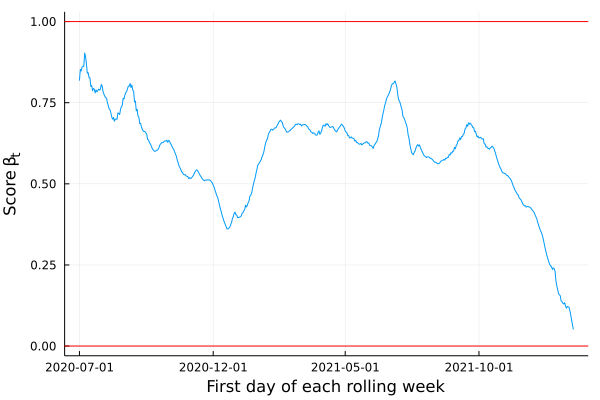

In [86]:
ScoreBetaHat_national_weekly = recoverBeta(Optim.minimizer(res_national_weekly), national_weekly);
plot(national_weekly.Date, ScoreBetaHat_national_weekly, 
label = :none,
xlabel = "First day of each rolling week",
ylabel = "Score \\beta_t")
hline!([0], color = :red, label = :none)
hline!([1], color = :red, label = :none)

In [106]:

national_weekly.ScoreBetaHat = ScoreBetaHat_national_weekly;
national_weekly.C_tilde_score = exp.(national_weekly.logCt .- 
national_weekly.ScoreBetaHat .* national_weekly.logNt .+
national_weekly.ScoreBetaHat .* nstar)
@df national_weekly plot(:Date, :Ct, yaxis = :log,
    label = "Observed log(Ct)", leg = :topleft, color = :green)
@df national_weekly plot!(:Date, :C_tilde_score, yaxis = :log,
    label = "Score Adjusted log(Ct*)", xlabel = "First day of each rolling week", ylabel = "Ct values", color = :red)
@df national_weekly plot!(:Date, :C_tilde, yaxis = :log,
    label = "log(C*hat)", leg = :bottomright, color = :blue)
#@df national_weekly plot!(twinx(),:Date, :Nt, yaxis = :log,
#    label = "Observed log(Nt)", leg = :bottomright, color = :black)
png("i2")

In [61]:
θ_national_7dd = [0, 0, 0, 0.3, 0, 0];  # ω, ϕ, α, σ, θ0, θ1
obj_national_7dd = θ_national_7dd -> logL(θ_national_7dd, national_7dd) 
res_national_7dd = optimize(obj_national_7dd, θ_national_7dd)
Optim.minimizer(res_national_7dd)  # Estimated static parameters

6-element Vector{Float64}:
  0.011397162074934597
  0.9519695333541391
 -0.02541871133672049
  0.29969801945936586
  0.08959833472993681
  0.717357488560508

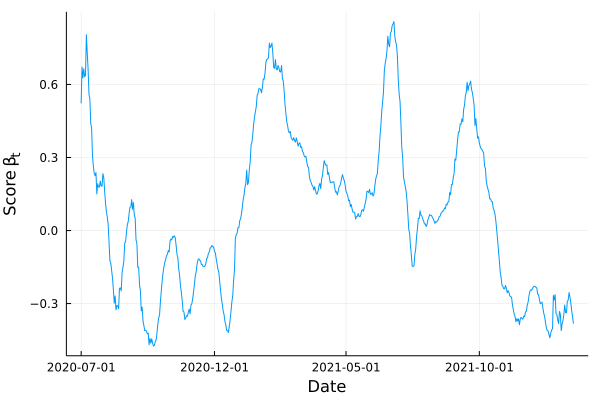

In [62]:
ScoreBetaHat_national_7dd = recoverBeta(Optim.minimizer(res_national_7dd), national_7dd);
plot(national_7dd.Date, ScoreBetaHat_national_7dd, 
label = :none,
xlabel = "Date",
ylabel = "Score \\beta_t")